# _(Brunel & Hakim, 1999)_ Fast Global Oscillation

Implementation of the paper:

- Brunel, Nicolas, and Vincent Hakim. "Fast global oscillations in networks of integrate-and-fire neurons with low firing rates." Neural computation 11.7 (1999): 1621-1671.

Author:

- Chaoming Wang (chao.brain@qq.com)

In [1]:
import brainpy as bp

In [2]:
Vr = 10.  # mV
theta = 20.  # mV
tau = 20.  # ms
delta = 2.  # ms
taurefr = 2.  # ms
duration = 100.  # ms
J = .1  # mV
muext = 25.  # mV
sigmaext = 1.  # mV
C = 1000
N = 5000
sparseness = float(C) / N

In [3]:
class LIF(bp.NeuGroup):
  target_backend = 'numpy'

  def f_v(self, V, t): return (-V + muext) / tau

  def g_v(self, V, t): return sigmaext / bp.math.sqrt(tau)

  def __init__(self, size, **kwargs):
    super(LIF, self).__init__(size, **kwargs)

    self.spike = bp.math.Variable(bp.math.zeros(self.num, dtype=bool))
    self.not_ref = bp.math.Variable(bp.math.ones(self.num, dtype=bool))
    self.V = bp.math.Variable(bp.math.ones(self.num) * Vr)
    self.t_last_spike = bp.math.Variable(-1e7 * bp.math.ones(self.num))

    self.int_v = bp.sdeint(f=self.f_v, g=self.g_v)

  def update(self, _t, _dt):
    for i in range(self.num):
      self.spike[i] = False
      self.not_ref[i] = False
      if (_t - self.t_last_spike[i]) > taurefr:
        V = self.int_v(self.V[i], _t)
        if V > theta:
          self.spike[i] = True
          self.V[i] = Vr
          self.t_last_spike[i] = _t
        else:
          self.V[i] = V
          self.not_ref[i] = True

In [4]:
class Syn(bp.TwoEndConn):
  target_backend = 'numpy'

  def __init__(self, pre, post, conn, delay, **kwargs):
    super(Syn, self).__init__(pre, post, conn=conn, **kwargs)

    self.pre2post = self.conn.requires('pre2post')
    self.g = self.register_constant_delay('g', post.num, delay=delay)

  def update(self, _t, _dt):
    s = bp.math.zeros(self.post.num)
    for pre_i, spike in enumerate(self.pre.spike):
      if spike:
        for post_i in self.pre2post[pre_i]:
          s[post_i] += J
    self.g.push(s)
    self.post.V -= self.g.pull() * self.post.not_ref

In [5]:
group = LIF(N, monitors=['spike'])
syn = Syn(pre=group, post=group, conn=bp.connect.FixedProb(sparseness), delay=delta)
net = bp.math.jit(bp.Network(group, syn))

Compilation used 1.4586 s.
Start running ...
Run 10.0% used 0.101 s.
Run 20.0% used 0.204 s.
Run 30.0% used 0.308 s.
Run 40.0% used 0.410 s.
Run 50.0% used 0.512 s.
Run 60.0% used 0.617 s.
Run 70.0% used 0.720 s.
Run 80.0% used 0.822 s.
Run 90.0% used 0.926 s.
Run 100.0% used 1.027 s.
Simulation is done in 1.028 s.



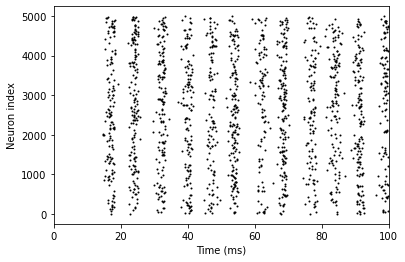

In [6]:
net.run(duration, report=0.1)
bp.visualize.raster_plot(group.mon.ts, group.mon.spike, xlim=(0, duration), show=True)